1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

# Keep warnings/style settings
warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2. Data Loading & Target Definition


In [2]:
# 2.1 Specify columns to read
usecols = [
    'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'Referee',
    'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR',
    'B365H', 'B365D', 'B365A', 'B365>2.5', 'B365<2.5'
]

file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 23-24.csv"
df = pd.read_csv(file_path, usecols=usecols)

# 2.2 Assign sequential MatchIndex and compute Round number
df['MatchIndex'] = df.index + 1
df['Round'] = np.ceil(df['MatchIndex'] / 10).astype(int)

# 2.3 Extract hour from kickoff Time and bucket into Morning/Afternoon/Evening
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins = [-1, 11, 17, 24]
labels = ['Morning', 'Afternoon', 'Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

# 2.4 Define regression target
#     - TotalYellows = sum of home and away yellow cards
#     - LogYellows   = log1p(TotalYellows) (computed for contingency only)
df['TotalYellows'] = df['HY'] + df['AY']
df['LogYellows'] = np.log1p(df['TotalYellows'])

print("Loaded shape:", df.shape)
df.head()

Loaded shape: (380, 29)


,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,...,B365H,B365D,B365A,B365>2.5,B365<2.5,MatchIndex,Round,TimeOfDay,TotalYellows,LogYellows
0,20:00,Burnley,Man City,0,3,A,C Pawson,6,17,1,...,8.00,5.5,1.33,1.67,2.20,1,1,Evening,0,0.000000
1,12:30,Arsenal,Nott'm Forest,2,1,H,M Oliver,15,6,7,...,1.18,7.0,15.00,1.44,2.75,2,1,Afternoon,4,1.609438
2,15:00,Bournemouth,West Ham,1,1,D,P Bankes,14,16,5,...,2.70,3.4,2.55,1.90,2.00,3,1,Afternoon,5,1.791759
3,15:00,Brighton,Luton,4,1,H,D Coote,27,9,12,...,1.33,5.5,9.00,1.62,2.30,4,1,Afternoon,4,1.609438
4,15:00,Everton,Fulham,0,1,A,S Attwell,19,9,9,...,2.20,3.4,3.30,2.01,1.89,5,1,Afternoon,2,1.098612


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Map full-time result to numeric Outcome (Home=1, Draw=0, Away=-1)
df['Outcome'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})

# 3.2 Implied probabilities from Bet365 odds (row-normalized)
for side in ['H', 'D', 'A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H', 'ImpProb_D', 'ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

# Over/Under 2.5 (row-normalized)
df['ImpOver2.5'] = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5', 'ImpUnder2.5']] = (
    df[['ImpOver2.5', 'ImpUnder2.5']]
      .div(df[['ImpOver2.5', 'ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread (Home minus Away)
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form (shifted to use only past games)
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks for home and away (shifted)
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.eq(1).shift(1).fillna(0).astype(int)
                    .groupby((~s.eq(1)).cumsum()).cumsum())
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.eq(-1).shift(1).fillna(0).astype(int)
                    .groupby((~s.eq(-1)).cumsum()).cumsum())
)

# 3.6 Interaction term: odds spread × home form
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias: past home wins / total matches (shifted)
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias'] = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins', 'RefMatches'], inplace=True)

# 3.8 Head-to-head last result (signed by home team)
df['PairKey'] = df.apply(lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev
df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match stats (shots, fouls, corners, cards) — leakage-free
home_stats = ['HS', 'HST', 'HF', 'HC', 'HY', 'HR']
away_stats = ['AS', 'AST', 'AF', 'AC', 'AY', 'AR']

for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
# assign points per match
df['HomePts'] = np.where(df['FTR'] == 'H', 3,
                         np.where(df['FTR'] == 'D', 1, 0))
df['AwayPts'] = np.where(df['FTR'] == 'A', 3,
                         np.where(df['FTR'] == 'D', 1, 0))

# build points-by-team-round
pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'], df['Round']]),
    'Pts':   np.concatenate([df['HomePts'], df['AwayPts']])
})

# cumulative points and ranking per round
round_pts = (
    pts.groupby(['Team', 'Round'], as_index=False)['Pts']
       .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos'] = (
    round_pts.groupby('Round')['CumPts']
             .rank(method='min', ascending=False)
)

# prepare previous-round lookup (PrevRound = Round + 1)
prev = round_pts[['Team', 'Round', 'Pos']].copy()
prev.rename(columns={'Round': 'PrevRound', 'Pos': 'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

# merge HomePrev position
df = df.merge(prev,
              left_on=['HomeTeam', 'Round'],
              right_on=['Team', 'PrevRound'],
              how='left')
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team', 'PrevRound', 'PrevPos'], inplace=True)

# merge AwayPrev position
df = df.merge(prev,
              left_on=['AwayTeam', 'Round'],
              right_on=['Team', 'PrevRound'],
              how='left')
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team', 'PrevRound', 'PrevPos'], inplace=True)

# 3.11 Home/Away position difference
df['PosDiff'] = df['HomePosPrev'] - df['AwayPosPrev']

4. Pipeline & Feature Schema (Support Vector Regression)

In [4]:
# 4.1 Categorical and numeric feature lists (kept identical to earlier schema)
cat_feats = ['HomeTeam', 'AwayTeam', 'Referee', 'TimeOfDay']

num_feats = [
    'HomeForm3', 'AwayForm3',
    'HomeStreak', 'AwayStreak',
    'ImpProb_H', 'ImpProb_D', 'ImpProb_A',
    'ImpOver2.5', 'ImpUnder2.5',
    'OddsSpread', 'Spread×Form',
    'RefBias', 'H2H_Last',
    'HomePosPrev', 'AwayPosPrev',
    'PosDiff'
]
num_feats += [f'Home_{stat}_3' for stat in ['HS','HST','HF','HC','HY','HR']]
num_feats += [f'Away_{stat}_3' for stat in ['AS','AST','AF','AC','AY','AR']]

# 4.2 Basic cleaning for features used by the pipeline
df[num_feats] = df[num_feats].fillna(0)
df['TimeOfDay'] = df['TimeOfDay'].astype(object).fillna('Afternoon')

# 4.3 Preprocessor: OneHot for categoricals, Standardize numerics
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor_svr = ColumnTransformer([
    ('num', num_pipeline, num_feats),
    ('cat', cat_encoder,  cat_feats),
], remainder='drop')

# 4.4 Model factories (SVR; log variant included because SVR can output negatives)
def make_model_svr(C=1.0, epsilon=0.1, kernel='rbf', gamma='scale'):
    """
    Support Vector Regression WITHOUT target log-transform.
    Note: SVR is unbounded and may produce negative predictions.
    """
    svr = SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
    return Pipeline([
        ('prep', preprocessor_svr),
        ('reg',  svr)
    ])

from sklearn.compose import TransformedTargetRegressor
def make_model_svr_log(C=1.0, epsilon=0.1, kernel='rbf', gamma='scale'):
    """
    Support Vector Regression WITH log1p target transform to enforce non-negative outputs.
    """
    svr = SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
    log_wrap = TransformedTargetRegressor(
        regressor=svr,
        func=np.log1p,
        inverse_func=np.expm1
    )
    return Pipeline([
        ('prep', preprocessor_svr),
        ('reg',  log_wrap)
    ])


5. Round-by-Round Training & Prediction (Support Vector Regression)

In [5]:

preds = []
preds_rounded = []
actuals = []
rounds = []
match_indices = []

warmup = 50
C = 1.0
epsilon = 0.1
kernel = 'rbf'
gamma = 'scale'

# 5.1 Initial warm-up fit on the first `warmup` matches
model = make_model_svr(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
model.fit(
    df.loc[:warmup-1, cat_feats + num_feats],
    df.loc[:warmup-1, 'TotalYellows']
)

# 5.2 Walk-forward per round (train on past rounds, predict current round)
for r in range(6, df['Round'].max() + 1):
    train_idx = df['Round'] < r
    test_idx  = df['Round'] == r

    X_train = df.loc[train_idx, cat_feats + num_feats]
    y_train = df.loc[train_idx, 'TotalYellows']

    X_test  = df.loc[test_idx,  cat_feats + num_feats]
    y_test  = df.loc[test_idx,  'TotalYellows']

    # Start with non-log SVR
    model = make_model_svr(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # If any negative predictions, refit with log-transform wrapper
    if np.any(y_pred < 0):
        model = make_model_svr_log(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)  # back on original scale via inverse_func

    preds.extend(y_pred.tolist())
    preds_rounded.extend(np.rint(y_pred).astype(int).tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))
    match_indices.extend(df.loc[test_idx, 'MatchIndex'].tolist())

print(f"Predicted rounds 6 to {df['Round'].max()}")

# 5.3 Save the final model for the Gradio interface
final_model = model

Predicted rounds 6 to 38


6. Results Export


In [6]:
# 6.1 Create a fast lookup by MatchIndex
df_idx = df.set_index('MatchIndex')

# 6.2 Collect Home/Away teams for each prediction
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

# 6.3 Build the results DataFrame with actual vs. predicted total yellows
results_df = pd.DataFrame({
    'MatchIndex':              match_indices,
    'Round':                   rounds,
    'HomeTeam':                homes,
    'AwayTeam':                aways,
    'ActualYellows':           actuals,
    'PredictedYellows':        preds,
    'PredictedYellowsRounded': preds_rounded
})

# 6.4 Save to disk (Excel)
output_path = r"D:\python\premier league predictor\predictions_vs_actuals_yellows.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)

Results written to D:\python\premier league predictor\predictions_vs_actuals_yellows.xlsx


7. Results & Visualization

C:\Users\markf\AppData\Local\Temp\ipykernel_5276\1978730839.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


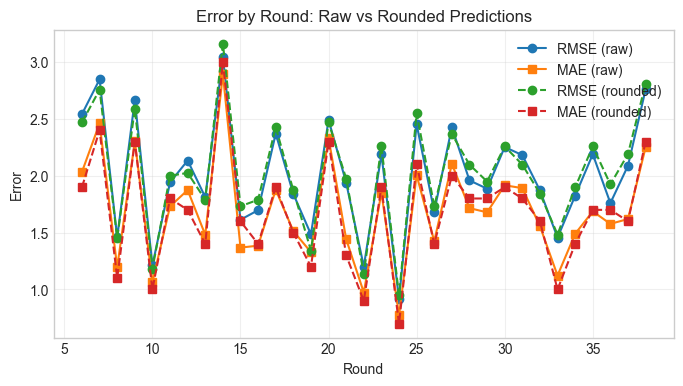

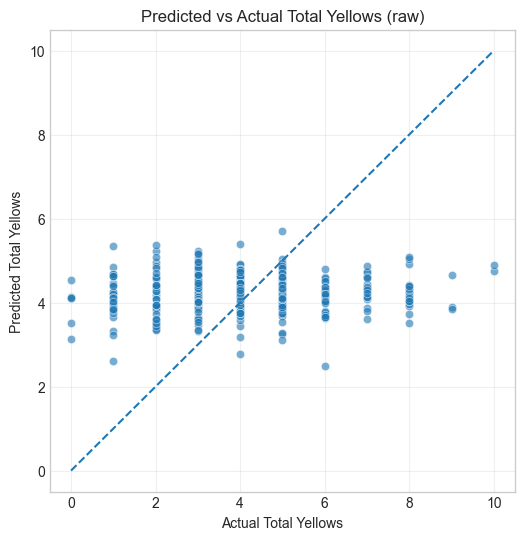

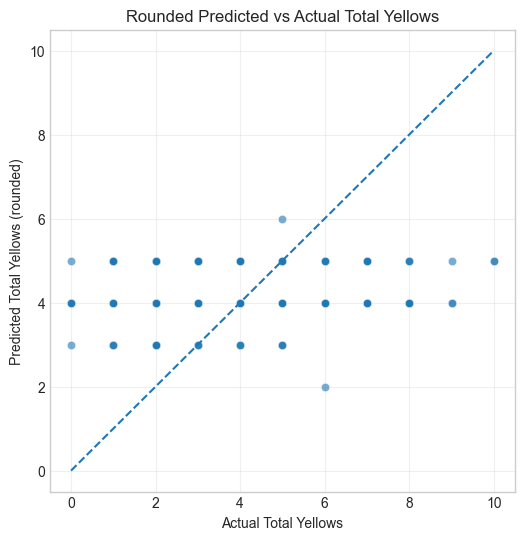

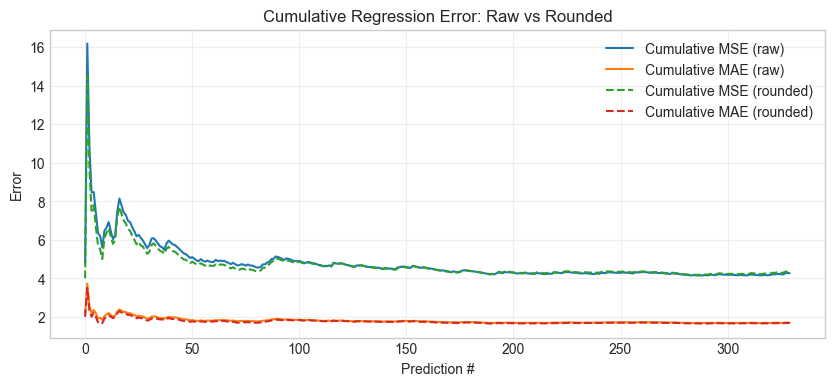

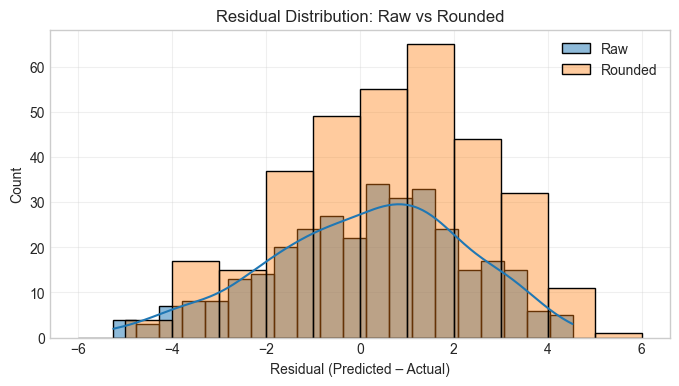

Over/Under 4.5 yellows accuracy: 50.91%


In [7]:
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# 7.1 Prepare DataFrame of predictions vs truths
res = pd.DataFrame({
    'Round':       rounds,
    'Pred':        preds,
    'PredRounded': preds_rounded,
    'True':        actuals
})

# 7.2 Round-by-round RMSE & MAE for raw and rounded predictions
round_stats = (
    res
    .groupby('Round')
    .apply(lambda g: pd.Series({
        'RMSE_raw':       np.sqrt(mean_squared_error(g['True'], g['Pred'])),
        'MAE_raw':        mean_absolute_error(g['True'], g['Pred']),
        'RMSE_rounded':   np.sqrt(mean_squared_error(g['True'], g['PredRounded'])),
        'MAE_rounded':    mean_absolute_error(g['True'], g['PredRounded'])
    }))
    .reset_index()
)

# 7.3 Plot RMSE & MAE by round (raw vs rounded)
plt.figure(figsize=(8, 4))
plt.plot(round_stats['Round'], round_stats['RMSE_raw'],      marker='o', label='RMSE (raw)')
plt.plot(round_stats['Round'], round_stats['MAE_raw'],       marker='s', label='MAE (raw)')
plt.plot(round_stats['Round'], round_stats['RMSE_rounded'],  marker='o', linestyle='--', label='RMSE (rounded)')
plt.plot(round_stats['Round'], round_stats['MAE_rounded'],   marker='s', linestyle='--', label='MAE (rounded)')
plt.xlabel('Round')
plt.ylabel('Error')
plt.title('Error by Round: Raw vs Rounded Predictions')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 7.4 Scatter: Predicted vs Actual (raw)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=res['True'], y=res['Pred'], alpha=0.6)
lims = [
    min(res['True'].min(), res['Pred'].min()),
    max(res['True'].max(), res['Pred'].max())
]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('Actual Total Yellows')
plt.ylabel('Predicted Total Yellows')
plt.title('Predicted vs Actual Total Yellows (raw)')
plt.grid(alpha=0.3)
plt.show()

# 7.5 Scatter: Predicted (rounded) vs Actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=res['True'], y=res['PredRounded'], alpha=0.6)
lims = [
    min(res['True'].min(), res['PredRounded'].min()),
    max(res['True'].max(), res['PredRounded'].max())
]
plt.plot(lims, lims, linestyle='--')
plt.xlabel('Actual Total Yellows')
plt.ylabel('Predicted Total Yellows (rounded)')
plt.title('Rounded Predicted vs Actual Total Yellows')
plt.grid(alpha=0.3)
plt.show()

# 7.6 Cumulative MSE & MAE over all predictions
cum_mse_raw   = [mean_squared_error(actuals[:i], preds[:i])            for i in range(1, len(preds)+1)]
cum_mae_raw   = [mean_absolute_error(actuals[:i], preds[:i])           for i in range(1, len(preds)+1)]
cum_mse_round = [mean_squared_error(actuals[:i], preds_rounded[:i])    for i in range(1, len(preds_rounded)+1)]
cum_mae_round = [mean_absolute_error(actuals[:i], preds_rounded[:i])   for i in range(1, len(preds_rounded)+1)]

plt.figure(figsize=(10, 4))
plt.plot(cum_mse_raw,   label='Cumulative MSE (raw)')
plt.plot(cum_mae_raw,   label='Cumulative MAE (raw)')
plt.plot(cum_mse_round, linestyle='--', label='Cumulative MSE (rounded)')
plt.plot(cum_mae_round, linestyle='--', label='Cumulative MAE (rounded)')
plt.xlabel('Prediction #')
plt.ylabel('Error')
plt.title('Cumulative Regression Error: Raw vs Rounded')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 7.7 Residual distributions (raw vs rounded)
residuals_raw   = np.array(preds)         - np.array(actuals)
residuals_round = np.array(preds_rounded) - np.array(actuals)

plt.figure(figsize=(8, 4))
sns.histplot(residuals_raw, bins=20, kde=True, label='Raw')
sns.histplot(
    residuals_round,
    bins=range(int(residuals_round.min())-1, int(residuals_round.max())+2),
    kde=False, alpha=0.4, label='Rounded'
)
plt.xlabel('Residual (Predicted – Actual)')
plt.title('Residual Distribution: Raw vs Rounded')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 7.8 Over/Under 4.5 yellows accuracy
threshold = 4.5
true_over = (res['True'] > threshold).astype(int)
pred_over = (res['Pred'] > threshold).astype(int)
ou_accuracy = accuracy_score(true_over, pred_over)
print(f"Over/Under {threshold} yellows accuracy: {ou_accuracy:.2%}")

8. Gradio Interface (Support Vector Regression)

In [8]:
import gradio as gr

# 8.1 Precompute means for odds-derived features used as fallbacks
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# 8.2 Dropdown choices for the UI
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# 8.3 Prediction function: returns raw and rounded total yellows
def predict_yellows(home_team, away_team, referee, time_of_day):
    # Pull latest historical rows for entities (fallback-safe)
    try:
        home_last = df[df.HomeTeam == home_team].iloc[-1]
    except IndexError:
        home_last = pd.Series(dtype=float)
    try:
        away_last = df[df.AwayTeam == away_team].iloc[-1]
    except IndexError:
        away_last = pd.Series(dtype=float)
    try:
        ref_last  = df[df.Referee == referee].iloc[-1]
    except IndexError:
        ref_last = pd.Series(dtype=float)

    # Odds-derived features (mean-imputed)
    feat = {
        'ImpProb_H':   odd_means['ImpProb_H'],
        'ImpProb_D':   odd_means['ImpProb_D'],
        'ImpProb_A':   odd_means['ImpProb_A'],
        'ImpOver2.5':  odd_means['ImpOver2.5'],
        'ImpUnder2.5': odd_means['ImpUnder2.5'],
        'OddsSpread':  odd_means['OddsSpread'],
    }

    # Team/ref history features
    feat['HomeForm3']   = float(home_last.get('HomeForm3', 0))
    feat['AwayForm3']   = float(away_last.get('AwayForm3', 0))
    feat['HomeStreak']  = float(home_last.get('HomeStreak', 0))
    feat['AwayStreak']  = float(away_last.get('AwayStreak', 0))
    feat['RefBias']     = float(ref_last.get('RefBias', 0.5))
    feat['HomePosPrev'] = float(home_last.get('HomePosPrev', 0))
    feat['AwayPosPrev'] = float(away_last.get('AwayPosPrev', 0))
    feat['PosDiff']     = feat['HomePosPrev'] - feat['AwayPosPrev']

    # Head-to-head last result, signed for current home
    h2h_mask = ((df['HomeTeam'] == home_team) & (df['AwayTeam'] == away_team)) | \
               ((df['HomeTeam'] == away_team) & (df['AwayTeam'] == home_team))
    if h2h_mask.any():
        last_h2h_row = df[h2h_mask].iloc[-1]
        h2h_val = float(last_h2h_row.get('H2H_Last', 0))
        if last_h2h_row['HomeTeam'] != home_team:
            h2h_val = -h2h_val
        feat['H2H_Last'] = h2h_val
    else:
        feat['H2H_Last'] = 0.0

    # Rolling stat features
    for stat in home_stats:
        feat[f'Home_{stat}_3'] = float(home_last.get(f'Home_{stat}_3', 0))
    for stat in away_stats:
        feat[f'Away_{stat}_3'] = float(away_last.get(f'Away_{stat}_3', 0))

    # Interaction term
    feat['Spread×Form'] = feat['OddsSpread'] * feat['HomeForm3']

    # Categorical features
    feat['HomeTeam']  = home_team
    feat['AwayTeam']  = away_team
    feat['Referee']   = referee
    feat['TimeOfDay'] = time_of_day

    # Assemble single-row DataFrame in exact schema
    X_row = pd.DataFrame([{**{k: feat[k] for k in cat_feats}, **{k: feat[k] for k in num_feats}}])
    for c in cat_feats:
        X_row[c] = X_row[c].astype(object)
    X_row[num_feats] = X_row[num_feats].fillna(0)

    # Predict using the final walk-forward SVR model
    y_pred = float(final_model.predict(X_row)[0])
    y_pred_round = int(np.rint(y_pred))

    return y_pred, y_pred_round

# 8.4 Gradio UI
iface = gr.Interface(
    fn=predict_yellows,
    inputs=[
        gr.Dropdown(choices=teams, label="Home Team"),
        gr.Dropdown(choices=teams, label="Away Team"),
        gr.Dropdown(choices=refs,  label="Referee"),
        gr.Dropdown(choices=times, label="Time of Day", value='Afternoon')
    ],
    outputs=[
        gr.Number(label="Predicted Total Yellows (raw)"),
        gr.Number(label="Predicted Total Yellows (rounded)")
    ],
    title="Premier League Total Yellows Predictor (SVR)",
    description=(
        "Select Home/Away teams, Referee, and Time of Day. "
        "Odds-derived features use historical averages; other features come from recent matches. "
        "The model is Support Vector Regression with walk-forward training."
    )
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.
